In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [29]:
mapping = [
           'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball',
           'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap',
           'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire',
           'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer',
           'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 'donut', 'door', 'dragon', 'dresser', 'drill',
           'harp', 'hat', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hexagon', 'hockey_puck', 'hockey_stick', 'horse',
           'hospital', 'hot_air_balloon', 'hot_dog', 'hot_tub', 'hourglass', 'house_plant', 'house', 'hurricane', 'ice_cream', 'jacket',
           'paper_clip', 'parachute', 'parrot', 'passport', 'peanut', 'pear', 'peas', 'pencil', 'penguin', 'piano',
           'popsicle', 'postcard', 'potato', 'power_outlet', 'purse', 'rabbit', 'raccoon', 'radio', 'rain', 'rainbow',
           'trombone', 'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 'washing_machine', 'watermelon',
]

In [30]:
NUM_OBJECTS = 100

In [31]:
class Generator():
    def __init__(self,filenames,labels,batch_size,device):
        self.image_filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.device = device
        
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        images = []
        for fname in batch_x:
            with open(fname,"rb") as f:
                images.append(np.divide(np.load(f),255.0))#normalize pixel values
        return torch.util.data.TensorDataset(torch.tensor(np.array(images),device=self.device), torch.tensor(np.array(batch_y),device=self.device))
    
    def dataset_iterator(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [32]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [33]:
from sklearn.model_selection import train_test_split

filenames = []
labels = []
for lab in range(NUM_OBJECTS):
    labels += [lab for _ in range(10_000)]
    for i in range(10_000):
        filenames.append(f"dataset/images/{lab}/{i}.npy")

labels = to_categorical(labels,NUM_OBJECTS)


train_X,test_X,train_y,test_y = train_test_split(filenames,labels,test_size=0.1)

train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size=0.22)

train_gen = Generator(train_X,train_y,32,device)
val_gen = Generator(val_X,val_y,16,device)

In [34]:
with torch.device(device):
    model = nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.LazyLinear(512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.LazyLinear(256),
        nn.ReLU(),
        nn.LazyLinear(128),
        nn.ReLU(),
        nn.LazyLinear(NUM_OBJECTS),
        nn.LogSoftmax(1)
    )

c:\Users\Jake\anaconda3\envs\gemma\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [35]:
def train_model(
        model:nn.Module,
        train_gen:Generator,
        val_gen:Generator,
        num_epochs:int = 50,
        num_early_stop:int = 10,
        num_lr_decrease:int = 3,
        lr_decrease_multiplier:float = 0.75,
        restore_best_weights:bool=True):
    
    loss_function = torch.nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters())

    best_accuracy = 0
    best_weights = None
    best_epoch = -1

    loss_values = []
    acc_values = []

    val_loss_values = []
    val_acc_values = []

    val_accs = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        model.train()  
        i = 0
        for X,y in train_gen.dataset_iterator():
            print(f"\tBatch {i}/{len(train_gen)}")
            i+=1
            opt.zero_grad()
            logits = model(X)
            loss = loss_function(logits, y)
            loss.backward()
            opt.step()
        model.eval()

In [36]:
train_model(model,train_gen,val_gen,num_epochs=2)

Epoch 0
	Batch 0/21938


RuntimeError: Input type (double) and bias type (float) should be the same

In [ ]:
def get_model(input_shape,num_outputs):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation="relu"),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dense(num_outputs,activation="softmax") #probability distribution output
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics="accuracy"
    )
    model.build()
    return model

In [ ]:
model = get_model((64,64,1),NUM_OBJECTS)

In [ ]:
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
model.fit(train_gen,
          epochs=50,
          validation_data=val_gen,
          callbacks=[
              tf.keras.callbacks.ReduceLROnPlateau(
                  monitor='val_accuracy', 
                  patience=3,
                  min_delta=0.0001,
                  factor=0.25,
                  min_lr=0.000001
                ),
              tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy', 
                  patience=6, 
                  verbose=2,
                  mode='max',
                  restore_best_weights=True
                ),
              tf.keras.callbacks.ModelCheckpoint(
                     filepath='./models/model_best.h5', 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', mode="max",
                     save_weights_only=True, save_best_only=True
                ),
              tensorboard_callback
          ])

Epoch 1/50
21938/21938 [==============================] - ETA: 0s - loss: 1.7626 - accuracy: 0.5529
Epoch 1: val_accuracy improved from -inf to 0.67878, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
21938/21938 [==============================] - 1231s 56ms/step - loss: 1.7626 - accuracy: 0.5529 - val_loss: 1.2391 - val_accuracy: 0.6788 - lr: 1.0000e-04
Epoch 2/50
21938/21938 [==============================] - ETA: 0s - loss: 1.2228 - accuracy: 0.6784
Epoch 2: val_accuracy improved from 0.67878 to 0.71340, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
21938/21938 [==============================] - 1113s 51ms/step - loss: 1.2228 - accuracy: 0.6784 - val_loss: 1.0907 - val_accuracy: 0.7134 - lr: 1.0000e-04
Epoch 3/50
21937/21938 [============================>.] - ETA: 0s - loss: 1.0758 - accuracy: 0.7150
Epoch 3: val_accuracy improved from 0.71340 to 0.73221, saving model to C:\Users\Jake\Desktop\ai-pl

Traceback (most recent call last):
  File "c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Jake\AppData\Local\Temp\ipykernel_16568\3351966550.py", line 1, in <module>
    model.fit(train_gen,
  File "c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\tensorfl

In [ ]:
model.load_weights('./models/model_best.h5')

In [ ]:
model.evaluate(Generator(test_X,test_y,16))

6250/6250 [==============================] - 89s 14ms/step - loss: 0.9471 - accuracy: 0.7565


[0.9470518231391907, 0.7565400004386902]

In [ ]:
model.save('./models/model_100obj.h5')

c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(64, 64, 1)


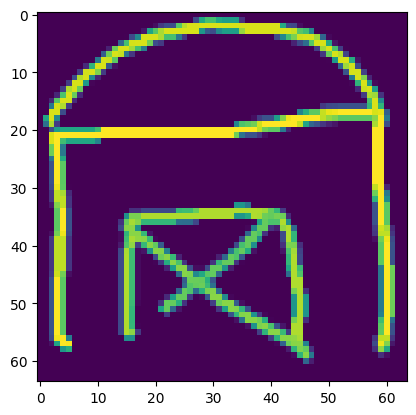

1/1 [==============================] - 0s 203ms/step
TRUE: barn,PREDICT: barn, 99.74%
(64, 64, 1)


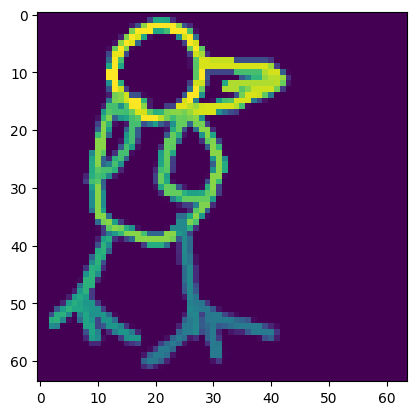

1/1 [==============================] - 0s 34ms/step
TRUE: bird,PREDICT: parrot, 64.49%
(64, 64, 1)


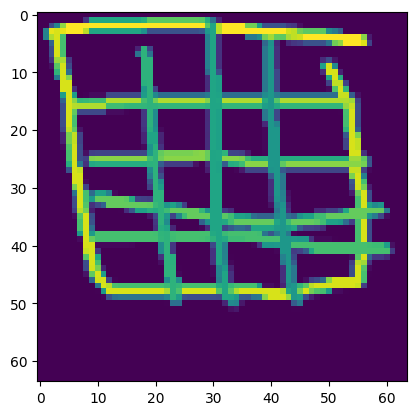

1/1 [==============================] - 0s 36ms/step
TRUE: calendar,PREDICT: calendar, 91.62%
(64, 64, 1)


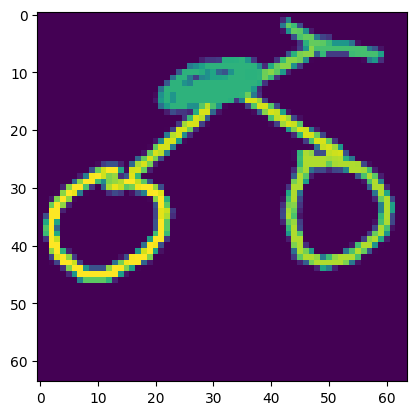

1/1 [==============================] - 0s 36ms/step
TRUE: bicycle,PREDICT: bicycle, 99.99%
(64, 64, 1)


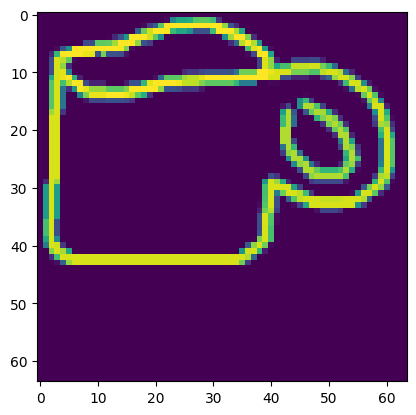

1/1 [==============================] - 0s 41ms/step
TRUE: coffee_cup,PREDICT: coffee_cup, 99.99%
(64, 64, 1)


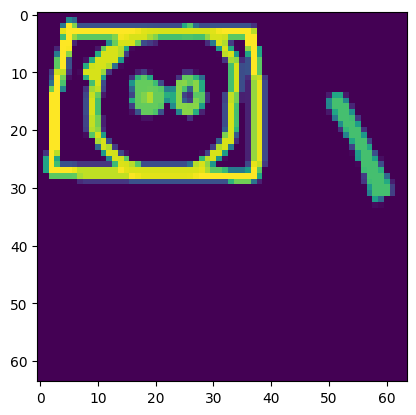

1/1 [==============================] - 0s 36ms/step
TRUE: power_outlet,PREDICT: power_outlet, 49.55%
(64, 64, 1)


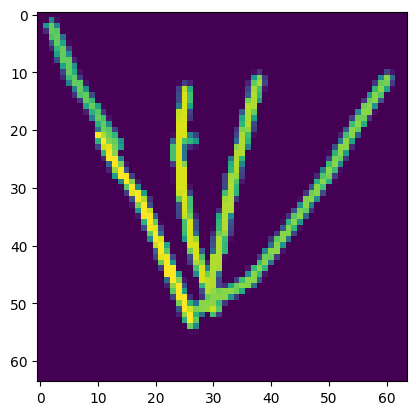

1/1 [==============================] - 0s 34ms/step
TRUE: diamond,PREDICT: diamond, 42.27%
(64, 64, 1)


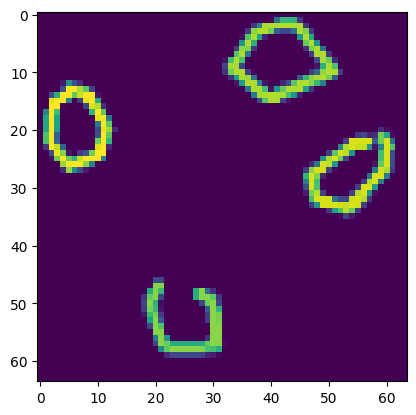

1/1 [==============================] - 0s 33ms/step
TRUE: peas,PREDICT: peas, 86.5%
(64, 64, 1)


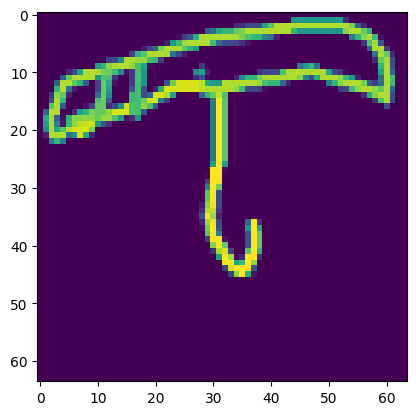

1/1 [==============================] - 0s 32ms/step
TRUE: umbrella,PREDICT: umbrella, 86.8%
(64, 64, 1)


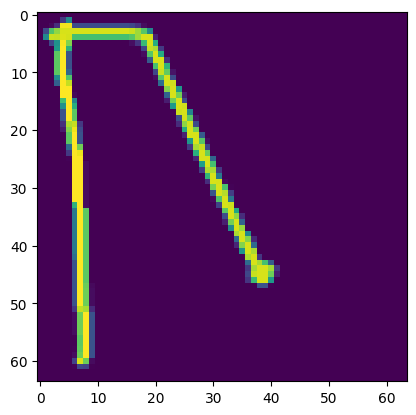

1/1 [==============================] - 0s 35ms/step
TRUE: door,PREDICT: popsicle, 25.86%


In [ ]:
from matplotlib import pyplot as plt

for i in range(10):
    fname = test_X[i]
    img = None
    with open(fname,"rb") as f:
        img = np.divide(np.load(f),255.0)
    print(img.shape)
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
    label = np.argmax(test_y[i])
    pred = model.predict(Generator([fname],[label],1))[0]
    pred_label = np.argmax(pred)
    perc = pred[pred_label]
    print(f'TRUE: {mapping[label]},PREDICT: {mapping[pred_label]}, {round(perc*100,2)}%')
    
